# Installation

In [1]:
! pip install duckdb

## Les autres librairies utiles

In [2]:
! pip install -r requirements.txt

In [3]:
import duckdb
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import zipfile
import os

In [4]:
! pip show matplotlib

Name: matplotlib
Version: 3.7.1
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /usr/local/lib/python3.10/dist-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: arviz, bigframes, datascience, fastai, geemap, imgaug, matplotlib-venn, missingno, mizani, mlxtend, music21, plotnine, prophet, pycocotools, seaborn, wordcloud, yellowbrick


# Se connecter à DuckDB

In [5]:
# Connexion à DuckDB
conn = duckdb.connect(database=':memory:', read_only=False)

# Exécution d'une requête SQL
cursor = conn.cursor()
cursor.execute("CREATE TABLE table_1(id INTEGER, name VARCHAR)")
cursor.execute("INSERT INTO table_1 VALUES (1, 'John'), (2, 'Alice'), (3, 'Bob')")

# Récupération des résultats de la requête
result = cursor.execute("SELECT * FROM table_1").fetchall()
print("Résultat de la requête : ", result)

# Fermeture de la connexion
conn.close()

Résultat de la requête :  [(1, 'John'), (2, 'Alice'), (3, 'Bob')]


# Convertir le fichier CSV en fichier parquet

In [6]:
# Charger le fichier CSV en utilisant pandas
patho = pd.read_csv('pathologies.csv', on_bad_lines='skip', sep=";", low_memory=False)

# Créer un tableau PyArrow à partir du DataFrame pandas
patho.to_parquet('pathologies.parquet')

# Explorer les données

Le fichier contient des données sur les pathologies et les patients.

Ce fichier est disponible en OpenData :
https://www.data.gouv.fr/fr/datasets/pathologies-effectif-de-patients-par-pathologie-sexe-classe-dage-et-territoire-departement-region/

## Charger le fichier parquet dans duckdb

In [7]:
conn = duckdb.connect(database=':memory:', read_only=False)

# Chargement du fichier Parquet
cursor = conn.cursor()
cursor.execute("CREATE TABLE pathologies AS SELECT * FROM parquet_scan('pathologies.parquet')")

# Affichage des 5 premières lignes
result = cursor.execute("SELECT * FROM pathologies LIMIT 5").fetchall()
print("Les 5 premières lignes du fichier Parquet : ", result)

Les 5 premières lignes du fichier Parquet :  [(2017.0, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 75, '999', 230570.0, 393250.0, 58.632, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017.0, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 76, '11', 14220.0, 24330.0, 58.451, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017.0, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-49', 9.0, 76, '12', 10630.0, 17390.0, 61.133, '1', 'de 45 à 49 ans', 'tous sexes', 17.0), (2017.0, 'Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire', None, None, 'sup_Petit_Conso_exclu', '45-4

## Le requeter en SQL

In [8]:
# Nombre total de lignes dans la table
total_rows = conn.execute("SELECT COUNT(*) AS total_rows FROM pathologies").fetchall()
print("Nombre total de lignes : ", total_rows)

# Nombre de colonnes dans la table
total_columns = conn.execute("SELECT COUNT(*) AS total_columns FROM information_schema.columns WHERE table_name = 'pathologies'").fetchall()
print("Nombre total de colonnes : ", total_columns)

Nombre total de lignes :  [(4057201,)]
Nombre total de colonnes :  [(16,)]


In [9]:
# Statistiques de base sur les colonnes
column_stats = conn.execute("""
    SELECT column_name, data_type
    FROM information_schema.columns
    WHERE table_name = 'pathologies'
""").fetchall()

print("Statistiques de base sur les colonnes :")
for column in column_stats:
    print(column)

Statistiques de base sur les colonnes :
('annee', 'DOUBLE')
('patho_niv1', 'VARCHAR')
('patho_niv2', 'VARCHAR')
('patho_niv3', 'VARCHAR')
('top', 'VARCHAR')
('cla_age_5', 'VARCHAR')
('sexe', 'DOUBLE')
('region', 'BIGINT')
('dept', 'VARCHAR')
('ntop', 'DOUBLE')
('npop', 'DOUBLE')
('prev', 'DOUBLE')
('niveau_prioritaire', 'VARCHAR')
('libelle_classe_age', 'VARCHAR')
('libelle_sexe', 'VARCHAR')
('tri', 'DOUBLE')


In [10]:
# Statistiques de base sur les données (pour les colonnes numériques)
numeric_columns_query = """
    SELECT column_name
    FROM information_schema.columns
    WHERE table_name = 'pathologies'
    AND data_type IN ('INTEGER', 'DOUBLE', 'FLOAT', 'DECIMAL')
"""
numeric_columns = conn.execute(numeric_columns_query).fetchall()

# Construction de la requête SQL pour les statistiques des colonnes numériques
stats_queries = []
for column in numeric_columns:
    column_name = column[0]
    stats_queries.append(f"""
        SELECT
            '{column_name}' AS column_name,
            AVG({column_name}) AS average,
            STDDEV({column_name}) AS standard_deviation,
            MIN({column_name}) AS min_value,
            MAX({column_name}) AS max_value
        FROM pathologies
    """)

# Exécution des requêtes de statistiques et affichage des résultats
print("Statistiques des colonnes numériques :")
print("Nom de colonne / Moyenne / Ecart type / Minimum / Maximum")
for query in stats_queries:
    result = conn.execute(query).fetchall()
    print(result)


Statistiques des colonnes numériques :
Nom de colonne / Moyenne / Ecart type / Minimum / Maximum
[('annee', 2018.0, 2.0000002464585522, 2015.0, 2021.0)]
[('sexe', 4.078260869565217, 3.5829257124948577, 1.0, 9.0)]
[('ntop', 5517.0258196033155, 158751.02365098946, 10.0, 68713080.0)]
[('npop', 102742.09854825988, 984640.6432691313, 10.0, 68713080.0)]
[('prev', 6.213842840217249, 15.98704679035494, 0.0, 100.0)]
[('tri', 39.40528634361233, 22.521721518030493, 1.0, 78.0)]


In [11]:
# Statistiques de base sur les données (pour les colonnes numériques)
get_disease_query = """
    SELECT DISTINCT patho_niv1
    FROM pathologies
"""
diseases = conn.execute(get_disease_query).fetchall()
for disease in diseases :
    print(disease)

('Séjours en hospitalisation complète pour prise en charge de la Covid-19',)
('Maladies neurologiques ou dégénératives',)
('Traitements psychotropes (hors pathologies)',)
('Maladies psychiatriques',)
('Autres affections de longue durée (dont 31 et 32)',)
(None,)
('Maternité (avec ou sans pathologies)',)
('Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)',)
('Pas de pathologies repérées, traitements, maternité, hospitalisations ni traitement antalgique ou anti-inflammatoire',)
('Traitements du risque vasculaire (hors pathologies)',)
('Maladies inflammatoires ou rares ou VIH ou SIDA',)
('Traitement antalgique ou anti-inflammatoire (hors pathologies, traitements, maternité ou hospitalisations)',)
('Cancers',)
('Maladies respiratoires chroniques (hors mucoviscidose)',)
('Insuffisance rénale chronique terminale',)
('Maladies du foie ou du pancréas (hors mucoviscidose)',)
('Diabète',)
('Maladies cardio-neurovasculaires',)


In [12]:
query = (f"""
        SELECT patho_niv1, dept, SUM(ntop), SUM(npop)
        FROM pathologies
        WHERE annee = 2018
        GROUP BY dept, patho_niv1
    """)

# Exécution des requêtes de statistiques et affichage des résultats
print("Statistiques par maladies en 2018:")
result = (conn.execute(query).fetchall())
pathologies = pd.DataFrame(result, columns=["patho_niv1", "departement", "malades", "pop"])
pathologies.insert(1, 'perc', pathologies['malades']/pathologies['pop'] * 100)
pathologies.head()

Statistiques par maladies en 2018:


,patho_niv1,perc,departement,malades,pop
0,Autres affections de longue durée (dont 31 et 32),2.320004,54,61620.0,2656030.0
1,Autres affections de longue durée (dont 31 et 32),2.515174,55,17570.0,698560.0
2,Autres affections de longue durée (dont 31 et 32),1.871691,68,54510.0,2912340.0
3,Autres affections de longue durée (dont 31 et 32),1.792356,53,21300.0,1188380.0
4,Autres affections de longue durée (dont 31 et 32),2.563885,47,33290.0,1298420.0


In [13]:
zip_path = 'gadm41_FRA_shp.zip'
extracted_path = 'extracted_shapefile'

if not os.path.exists(extracted_path):
    os.makedirs(extracted_path)

# Extraire les fichiers du zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Trouver le fichier shapefile (.shp)
shapefile_path = None
for root, dirs, files in os.walk(extracted_path):
    for file in files:
        if file.endswith('.shp'):
            shapefile_path = os.path.join(root, file)
            break

In [14]:
disease_to_plot = 'Cancers'
pathologies_filtered = pathologies[pathologies['patho_niv1'] == disease_to_plot]

gdf = gpd.read_file('extracted_shapefile/gadm41_FRA_2.shp')
#gdf = gpd.read_file('france.shp')

gdf['code'] = gdf['CC_2'].astype(str).str.zfill(2)
pathologies_filtered['departement'] = pathologies_filtered['departement'].astype(str).str.zfill(2)

# Joindre les données géographiques avec les données de patients
merged = gdf.set_index('code').join(pathologies_filtered.set_index('departement'))
print(merged.columns)

Index(['GID_2', 'GID_0', 'COUNTRY', 'GID_1', 'NAME_1', 'NL_NAME_1', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'geometry', 'patho_niv1', 'perc', 'malades', 'pop'],
      dtype='object')


<ipython-input-14-9ff562c1aef2>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pathologies_filtered['departement'] = pathologies_filtered['departement'].astype(str).str.zfill(2)


<ipython-input-15-fba844c21da8>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge


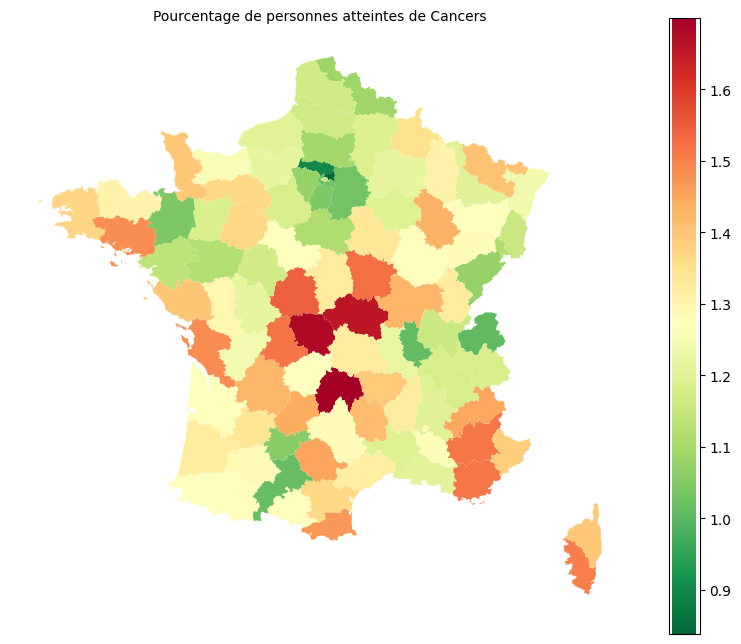

In [15]:
variable_to_plot = "perc"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged[variable_to_plot].min(), vmax=merged[variable_to_plot].max())
cmap = plt.cm.get_cmap('RdYlGn_r')  # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
cbar = ax.get_figure().get_axes()[1]
cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f'Pourcentage de personnes atteintes de {disease_to_plot}', fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()

# Charger les données sur les points de vente de tabac

In [16]:
# Charger le fichier CSV en utilisant pandas
tabac = pd.read_csv('tabacs.csv', on_bad_lines='skip', sep=";", low_memory=False, encoding='latin-1')

# Créer un tableau PyArrow à partir du DataFrame pandas
tabac.to_parquet('tabac.parquet')

# Chargement du fichier Parquet
cursor = conn.cursor()
cursor.execute("CREATE TABLE tabac AS SELECT * FROM parquet_scan('tabac.parquet')")

# Affichage des 5 premières lignes
result = cursor.execute("SELECT * FROM tabac LIMIT 5").fetchall()
print("Les 5 premières lignes du fichier Parquet : ", result)

Les 5 premières lignes du fichier Parquet :  [(None, '42 RUE ROGER VAILLANT', 1500, 'AMBERIEU EN BUGEY', 'Ordinaire permanent'), ('TABAC DE LA GARE', '6 AV DU GENERAL SARRAIL', 1500, 'AMBERIEU EN BUGEY', 'Ordinaire permanent'), ('MAISON DE LA PRESSE', '14 R BERARD', 1500, 'AMBERIEU EN BUGEY', 'Ordinaire permanent'), (None, '8 AV  PAUL PAINLEVE', 1500, 'AMBERIEU EN BUGEY', 'Ordinaire permanent'), ('LA ROSERAIE', '33, rue de la ruelle', 1330, 'AMBERIEUX EN DOMBES', 'Ordinaire permanent')]


In [17]:
tabac['departement'] =  tabac['Code postal débit'].astype(str).str[:-3]
tabac['departement'] =  tabac['departement'].str.zfill(2)
tabac_count = tabac.groupby('departement', group_keys=True, as_index=False).count()
tabac_count = tabac_count.filter(['Enseigne débit', 'departement'], axis=1)
tabac_count.head()

,Enseigne débit,departement
0,146,01
1,107,02
2,13,03
3,77,04
4,69,05


In [18]:
merged = merged.join(tabac_count.set_index('departement'))

In [19]:
merged["tabac/hab"] = merged["Enseigne débit"]/merged["pop"]*1000000
merged.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry,patho_niv1,perc,malades,pop,Enseigne débit,tabac/hab
code,,,,,,,,,,,,,,,,,,,,
01,FRA.1.1_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Ain,NA,NA,Département,Department,01,FR.AI,"POLYGON ((5.62375 45.61327, 5.61491 45.62541, ...",Cancers,1.160498,368410.0,31745860.0,146.0,4.599025
03,FRA.1.2_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Allier,Basses-Alpes,NA,Département,Department,03,FR.AL,"POLYGON ((3.67802 45.95596, 3.66664 45.96115, ...",Cancers,1.657467,286320.0,17274550.0,13.0,0.752552
07,FRA.1.3_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Ardèche,NA,NA,Département,Department,07,FR.AH,"POLYGON ((4.14166 44.32396, 4.12675 44.33773, ...",Cancers,1.318670,224250.0,17005770.0,138.0,8.114893
15,FRA.1.4_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Cantal,NA,NA,Département,Department,15,FR.CL,"POLYGON ((3.06419 44.82031, 3.04827 44.80426, ...",Cancers,1.699955,124640.0,7331960.0,83.0,11.320302
26,FRA.1.5_1,FRA,France,FRA.1_1,Auvergne-Rhône-Alpes,NA,Drôme,NA,NA,Département,Department,26,FR.DM,"POLYGON ((5.44757 44.13676, 5.43837 44.13881, ...",Cancers,1.199469,327060.0,27267070.0,158.0,5.794535


<ipython-input-20-43586c110086>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r') # Utilisation de 'RdYlGn_r' pour aller du vert au rouge


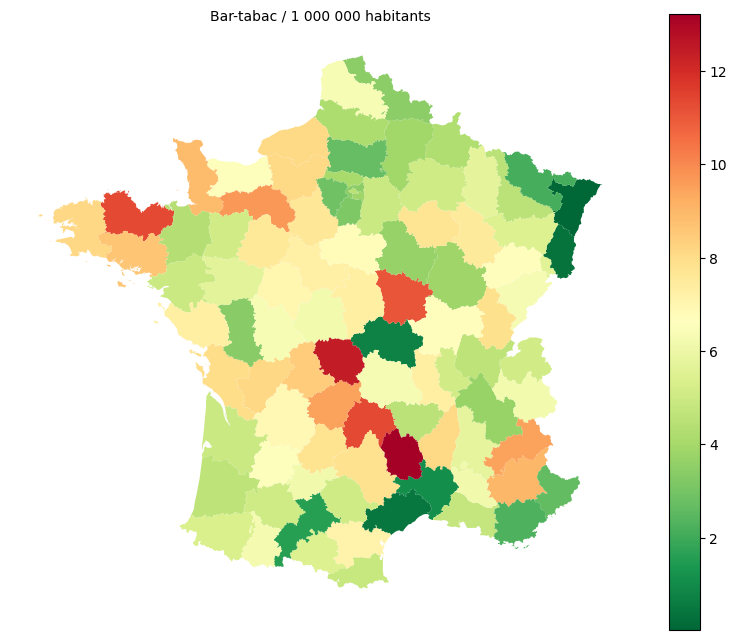

In [20]:
variable_to_plot = "tabac/hab"

# Définir les valeurs de coloration
norm = mcolors.Normalize(vmin=merged[variable_to_plot].min(), vmax=merged[variable_to_plot].max())
#norm = mcolors.Normalize(vmin=1500, vmax=30000)
cmap = plt.cm.get_cmap('RdYlGn_r') # Utilisation de 'RdYlGn_r' pour aller du vert au rouge

# Créer la carte
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
merged.plot(column=variable_to_plot, cmap=cmap, norm=norm, legend=True, ax=ax)

# Supprimer les axes gradués
ax.set_axis_off()

# Ajuster la taille de la barre colorée (legend)
#cbar = ax.get_figure().get_axes()[1]
#cbar.set_aspect(30)  # Ajuster la taille selon vos besoins

# Ajouter un titre
ax.set_title(f"Bar-tabac / 1 000 000 habitants", fontdict={'fontsize': '10', 'fontweight': '3'})

# Afficher la carte
plt.show()


### Quelle est la corrélation ?

In [21]:
print(merged['tabac/hab'].corr(merged['perc']))

0.4249239637951251


# Fermer la connexion

In [22]:
conn.close()